In [34]:
!pip install -U langgraph langsmith
!pip install python-dotenv langchain[groq]
!pip install -U langchain-tavily

In [35]:
from google.colab import userdata
import os

os.environ["GROQ_API_KEY"] = userdata.get('groqApiKey')
os.environ["TAVILY_API_KEY"] = userdata.get('tavili')

In [36]:
from langgraph.checkpoint.memory import InMemorySaver

memory = InMemorySaver()

In [37]:
from typing import Annotated

from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages


class State(TypedDict):

    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)


In [38]:
from langchain_tavily import TavilySearch

tool = TavilySearch(max_results=1)
tools = [tool]
tool.invoke("What's a 'node' in LangGraph?")

{'query': "What's a 'node' in LangGraph?",
 'follow_up_questions': None,
 'answer': None,
 'images': [],
 'results': [{'url': 'https://www.ibm.com/think/topics/langgraph',
   'title': 'What is LangGraph? - IBM',
   'content': 'LangGraph, created by LangChain, is an open source AI agent framework designed to build, deploy and manage complex generative AI agent workflows. At its core, LangGraph uses the power of graph-based architectures to model and manage the intricate relationships between various components of an AI agent workflow. LangGraph illuminates the processes within an AI workflow, allowing full transparency of the agent’s state. By combining these technologies with a set of APIs and tools, LangGraph provides users with a versatile platform for developing AI solutions and workflows including chatbots, state graphs and other agent-based systems. **Nodes**: In LangGraph, nodes represent individual components or agents within an AI workflow. LangGraph uses enhanced decision-maki

In [39]:
from langchain.chat_models import init_chat_model
from langgraph.prebuilt import ToolNode, tools_condition
llm = init_chat_model("qwen/qwen3-32b", model_provider="groq")




llm_with_tools = llm.bind_tools(tools)

In [40]:
def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}



graph_builder.add_node("chatbot", chatbot)

tool_node = ToolNode(tools=[tool])
graph_builder.add_node("tools", tool_node)

graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)
graph_builder.add_edge("tools", "chatbot")

graph_builder.add_edge(START, "chatbot")

graph_builder.add_edge("chatbot", END)







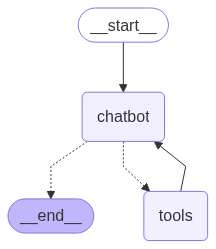

In [41]:
graph = graph_builder.compile(checkpointer=memory)
#Visualize the graph

from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [42]:
config = {"configurable": {"thread_id": "1"}}
def stream_graph_updates(user_input: str):
    for event in graph.stream({"messages": [{"role": "user", "content": user_input}]}, config):
        for value in event.values():
            print("Assistant:", value["messages"][-1].content)




In [44]:
while True:
    try:
        user_input = input("User: ")
        if user_input.lower() in ["quit", "exit", "q"]:
            print("Goodbye!")
            break
        stream_graph_updates(user_input)
    except:
        # fallback if input() is not available
        # user_input = "What do you know about LangGraph?"
        print("User: " + user_input)
        stream_graph_updates(user_input)
        break


User: my name is mira
Assistant: Hello again, Mira! How can I assist you today? 😊
User: remember my name
Assistant: I'm designed to assist with your queries using the tools provided, but I don't have a memory system to retain personal information like your name between sessions. If you'd like me to address you by name during our current conversation, feel free to mention it each time! How can I help you today, Mira? 😊
User: who is pm in india
Assistant: 
Assistant: {"query": "Current Prime Minister of India", "follow_up_questions": null, "answer": null, "images": [], "results": [{"url": "https://www.jagranjosh.com/general-knowledge/list-of-all-prime-ministers-of-india-1473165149-1", "title": "List of all Prime Ministers of India (1947-2025) - Jagran Josh", "content": "Aug 22, 2025·Currently, Narendra Modi is the Prime Minister of India, having been in office since 2014. He is the 14th Prime Minister of India who had three", "score": 0.90593183, "raw_content": null}], "response_time": 0